# Import all libraries

In [1]:
import numpy as np
import torch
import networkx as nx
from tqdm import tqdm

from Architecture.Layers import Random_RNN
import matplotlib.pyplot as plt

In [2]:
input_size = 2
hidden_size = 10
output_size = 3
device = "cpu"

model = Random_RNN(input_size, output_size, hidden_size, connect_percentage=0.0).to(device)

print(f'nodes: {len(model.graph.nodes)}\n edges: {len(model.graph.edges)}')

nodes: 15
 edges: 23


In [3]:
# Create test data vector and forward the model
model.reset_neurons_memory()
model.reset_neurons_states()

test_individ = torch.ones(input_size)
out, time = model.forward(test_individ.view(-1, input_size), return_work_time=True)
print(f"Output: {out.detach().numpy()} \nWork time of network: {time} iter.")

Output: [-0.13858433 -0.2594935  -0.09335449] 
Work time of network: 3 iter.


In [4]:
# # Show all nodes data
# for i, data in model.graph.nodes(data=True):
#     print(i, data['type'], data['status'])

In [5]:
# from torchsummary import summary

# show model summary
# summary(model, (input_size, ), device='cpu')
# model.graph.edges()

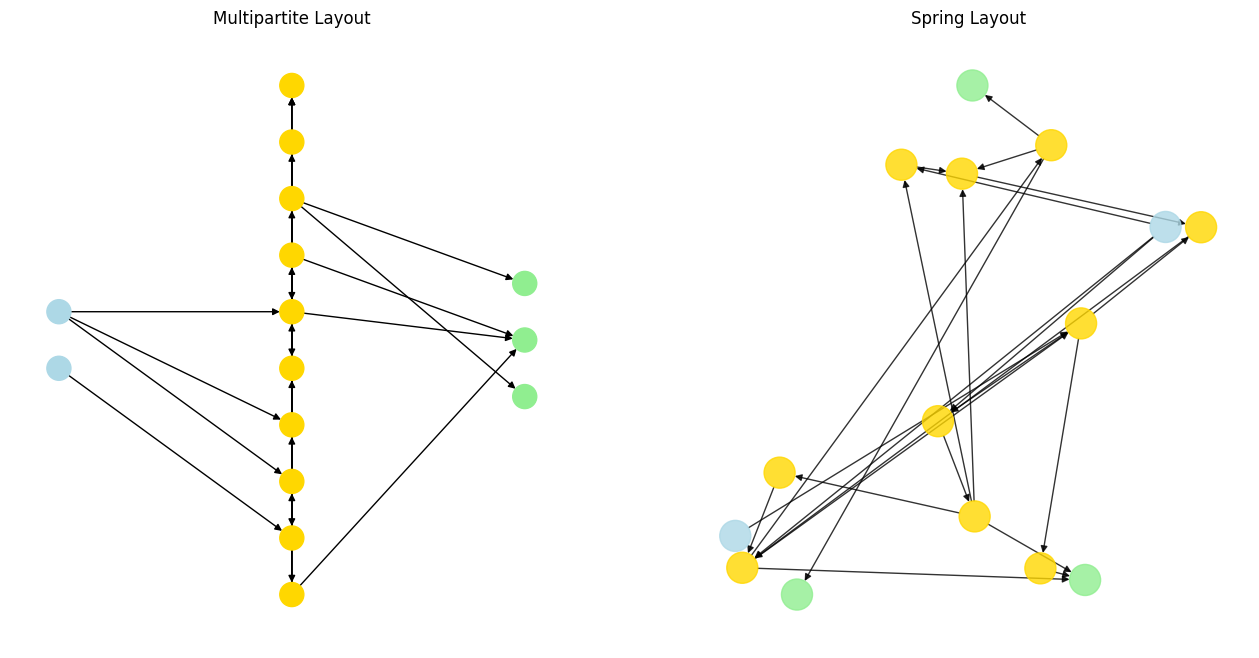

In [6]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
pos = nx.multipartite_layout(model.graph, subset_key="layer")
nx.draw(model.graph, pos, node_color=[n[1]["color"] for n in model.graph.nodes(data=True)], with_labels=False)
plt.title('Multipartite Layout')

plt.subplot(122)
nx.draw(model.graph, node_color=[n[1]["color"] for n in model.graph.nodes(data=True)], node_size=500, alpha=0.8, with_labels=False)
plt.title('Spring Layout')

plt.show()

# Dataset
The dataset consist of 3 clusters in 2 dimension space.

In [7]:
from sklearn.datasets import make_blobs

# Generate points
X, Y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=0.7, random_state=0)

# Normalize dataset
X = (X - X.min()) / (X.max() - X.min())

# Convert Y to one-hot
Y = np.eye(3)[Y]

# Convert to tensors
X = torch.from_numpy(X).float()
Y = torch.from_numpy(Y).float()

# Create dataset
dataset = torch.utils.data.TensorDataset(X, Y)

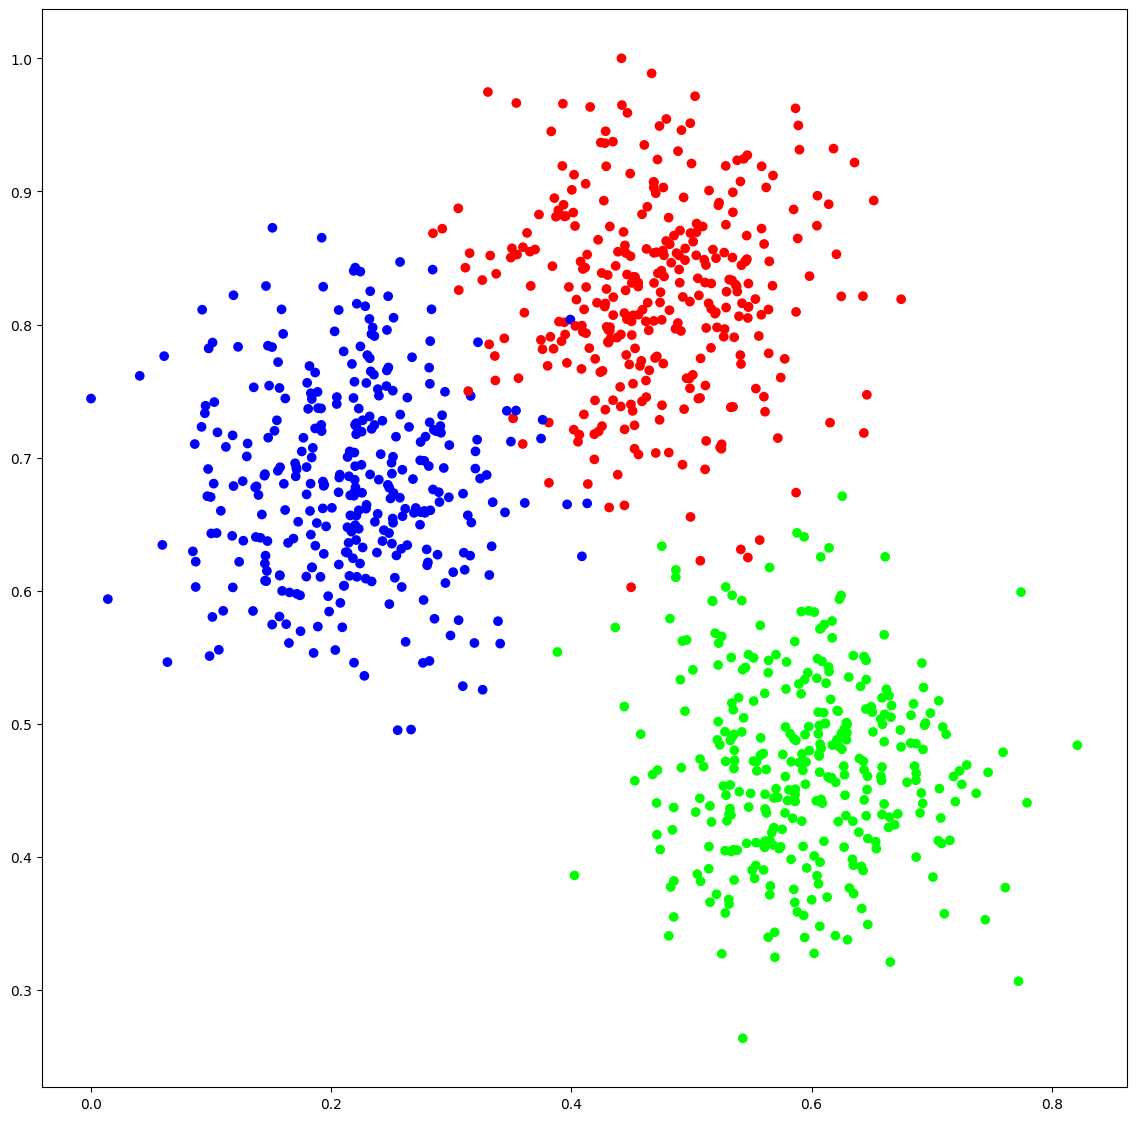

In [8]:
# Visualize dataset
plt.figure(figsize = (14, 14))
plt.scatter([i[0] for i in X], [i[1] for i in X], c=Y)
plt.show()

In [9]:
split_ratio = 0.90
batch_size = 1
train_size = round(len(dataset) * split_ratio)
valid_size = len(dataset) - train_size

train, valid = torch.utils.data.random_split(dataset, [train_size, valid_size])

train_batch_loader = torch.utils.data.DataLoader2(train, batch_size=batch_size, collate_fn=lambda x: tuple(x_.to(device) for x_ in torch.utils.data.dataloader.default_collate(x)))
valid_batch_loader = torch.utils.data.DataLoader2(valid, batch_size=batch_size, collate_fn=lambda x: tuple(x_.to(device) for x_ in torch.utils.data.dataloader.default_collate(x)))

# Validate untrained model
Validating the model with random initialized weights (not trained)

In [10]:
from sklearn.metrics import f1_score, accuracy_score

def validate(model, valid_batch_loader):
    # Create empty lists to store predictions and labels
    predictions = []
    labels = []

    # Iterate over validation set
    for i, (features, ans) in enumerate(valid_batch_loader):
        # Forward pass
        Y_pred, time = model.forward(features.view(-1, input_size), return_work_time=True)

        # Get prediction
        prediction = torch.argmax(Y_pred, dim=0).item()

        # Append to lists
        predictions.append(prediction)
        labels.append(torch.argmax(ans, dim=1).item())

    # Calculate metrics
    f1 = f1_score(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)

    return f1, acc

In [11]:
sample_size = 20
f1 = []
acc = []
for i in tqdm(range(sample_size), desc='Validation', leave=False, colour='green'):
    model.restruct(connect_percentage=0.0)
    f1_i, acc_i = validate(model, valid_batch_loader)
    f1.append(f1_i)
    acc.append(acc_i)

print(f'F1: {np.mean(f1)}\nACC: {np.mean(acc)}')

                                                           7.02it/s]

F1: 0.1855962005019002
ACC: 0.333


# Train loop

In [12]:
# Configure hyper-parameters
epochs = 10
learning_rate = 3e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

history = []
torch.autograd.set_detect_anomaly(True)

In [13]:
for epoch in range(0, epochs):
    for i, (features, ans) in enumerate(tqdm(train_batch_loader, desc=f'Epoch {epoch}', leave=False, colour='green')):
        # Forward pass
        Y_pred = model.forward(features.view(-1, input_size))
        print(Y_pred, ans)


        # Calculate loss
        loss = loss_func(Y_pred.view(-1, 1), ans.view(-1, 1))

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        history.append(loss.data)

Epoch 0:   0%|          | 1/900 [00:00<01:55,  7.76it/s]

tensor([ 0.0824, -0.0079, -0.0188], grad_fn=<CopySlices>) tensor([[0., 0., 1.]])


/home/leon/Projects/Programming/Random-Graph-RNN/venv/lib/python3.7/site-packages/torch/autograd/__init__.py:199: UserWarning: Error detected in MulBackward0. Traceback of forward call that caused the error:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/leon/Projects/Programming/Random-Graph-RNN/venv/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/leon/Projects/Programming/Random-Graph-RNN/venv/lib/python3.7/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/home/leon/Projects/Programming/Random-Graph-RNN/venv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/home/leon/Projects/Programming/Random-Graph-RNN/venv/lib/python3.7/site-packages/tornado/platform/asynci

tensor([ 0.0857, -0.0257, -0.0196], grad_fn=<CopySlices>) tensor([[1., 0., 0.]])


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [1]], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [ ]:
# Plot loss history
plt.figure(figsize=(16, 8))
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.show()

# Validate trained model

In [ ]:
f1, acc = validate(model, valid_batch_loader)
print(f'F1: {f1}\nACC: {acc}')

# Load MNIST

In [ ]:
dataset = torchvision.datasets.MNIST(root = 'datasets', train = True, download = True, transform=torchvision.transforms.ToTensor())

#### Get and visualize random individual

In [ ]:
rand_individ = random.randint(0, 60_000)
img = dataset[rand_individ][0].view((28, 28))
ans = dataset[rand_individ][1]
plt.imshow(img, cmap='plasma')
plt.xlabel(f"NUMBER: {ans}")
pass

# Prepare and split data into train/test

In [ ]:
split_ratio = 0.00005
batch_size = 1
train_size = round(len(dataset) * split_ratio)
valid_size = len(dataset) - train_size

# print(dataset.shape)
print(dataset)

train, valid = torch.utils.data.random_split(dataset, [train_size, valid_size])

train_batch_loader = torch.utils.data.DataLoader2(train, batch_size=batch_size, collate_fn=lambda x: tuple(x_.to(device) for x_ in torch.utils.data.dataloader.default_collate(x)))
valid_batch_loader = torch.utils.data.DataLoader2(valid, batch_size=batch_size, collate_fn=lambda x: tuple(x_.to(device) for x_ in torch.utils.data.dataloader.default_collate(x)))

# Configure NN Model and hyper-parameters

# Train loop

# Validation

# Visualisation test

In [ ]:
rand_individ = random.randint(0, 60_000)
img = dataset[rand_individ][0].view((28, 28))
ans = dataset[rand_individ][1]


with torch.no_grad():
    pred = mnist_nn(img.to(device).view(-1)).argmax()

plt.imshow(img, cmap='Greys')
plt.xlabel(f"PREDICTION: {pred}, ANSWER {ans}")
pass